In [11]:
## Grad Cam Visualization

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
!pip install -U pyYAML


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import seaborn as sns
import yaml
import matplotlib.pyplot as plt
import keras

from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Dense, Flatten, AveragePooling2D, Dropout, MaxPool2D
from tensorflow.keras.optimizers import Adam
from keras.applications.xception import Xception
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.layers import Dense, MaxPool2D, Conv2D

import matplotlib.cm as cm
from IPython.display import Image, display


In [15]:
cfg = yaml.full_load(open("/content/drive/MyDrive/FP/config.yml", 'r'))

In [23]:
test_data = pd.read_csv(cfg['PATHS']['TEST_SET'])

In [16]:
from keras.models import load_model
model = load_model("/content/drive/MyDrive/FP/models/vgg_model.h5")
model.layers[-1].activation = None

In [17]:
class_type = {0: 'Covid',1:'Normal',2:'Viral Pneumonia'}

In [18]:
def get_img_array(img_path):
  path = img_path
  img = image.load_img(path, target_size=(224,224,3))
  img = image.img_to_array(img)
  img = np.expand_dims(img , axis= 0 )
  
  return img

In [19]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
          pred_index = tf.argmax(preds[0])
        
        class_channel = preds[:,pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [26]:
def save_and_display_gradcam(img_path , heatmap, cam_path="cam.jpg", alpha=0.4):
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255* heatmap)

    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)

    # display(Image(cam_path))
    return cam_path

In [27]:
def image_prediction_and_visualization(path,last_conv_layer_name = "block5_conv3", model = model):
  img_array = preprocess_input(get_img_array(path))
  heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

  fig, ax = plt.subplots(1, 3, figsize=(20, 20))
  ax[1].imshow(heatmap)

  img = get_img_array(path)

  res = class_type[np.argmax(model.predict(img))]

  img_path = save_and_display_gradcam(path, heatmap)
  ax[2].imshow(plt.imread(img_path))
  a = plt.imread(path)
  ax[0].imshow(a, cmap = "gray")
  plt.title("Predicted: " + res)
  plt.show()

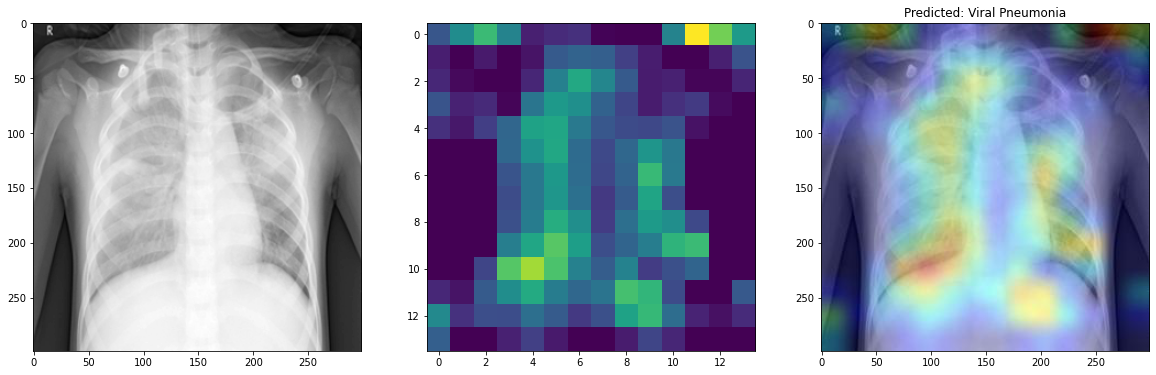

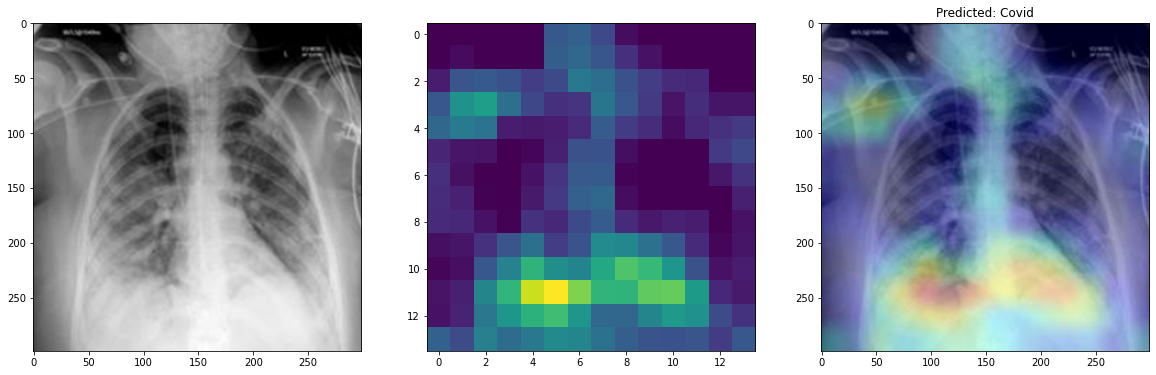

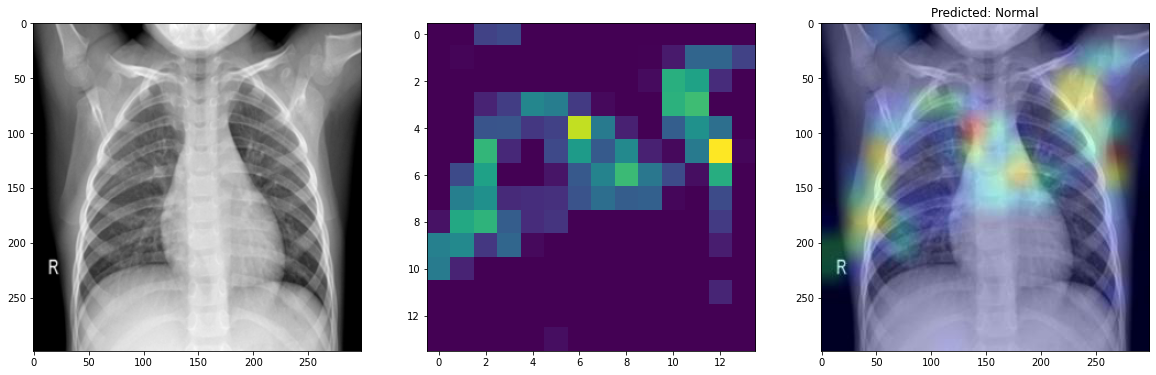

In [30]:
sample_images = test_data.sample(3)["filename"]
for i,path in enumerate(sample_images):
    image_prediction_and_visualization(path)